### Camera Simulator

This is a first stab at a camera simulator using python. ChatGPT was used for reference and Q&A.

Import necessary libraries first

In [2]:
!pip install imageio
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

Define the parameters of the images and/or sensor that will be used below

In [3]:
image_width = 2048
image_height = 2048
exposure_time = 10  # Exposure time in seconds (?)
scene_type = "Simple SpecRad" # choose scene option
mean_luminance = 100 # cd/m2. Used only for scene 3

In [4]:
# Define Noise Functions

# Simulate photon shot noise
def simulate_photon_noise(image, exposure_time):
    """
    Simulates photon shot noise. This noise is inherent to the randomness of photon arrivals.
    :param image: The initial image data (electron counts).
    :return: Simulated image data with added photon noise.
    """
    scaled_image = image * exposure_time
    poisson_noise = np.random.poisson(scaled_image) / exposure_time
    return np.clip(poisson_noise, 0, 255)  # Clip values to [0, 255]

# Simulate read noise
def simulate_read_noise(image, read_noise_std):
    """
    Simulates read noise. This noise is introduced during the readout process of the sensor.
    :param image: The image data (electron counts) before read noise.
    :param read_noise_std: Standard deviation of the read noise.
    :return: Simulated image data with added read noise.
    """
    noisy_image = image + np.random.normal(0, read_noise_std, image.shape)
    return np.clip(noisy_image, 0, 255)  # Clip values to [0, 255]

# Simulate dark current noise
def simulate_dark_current(image, dark_current_rate, exposure_time):
    """
    Simulates dark current noise. Dark current is generated by the sensor even in the absence of light.
    :param image: The image data (electron counts) before dark current noise.
    :param dark_current_rate: Dark current rate in electrons per second per pixel.
    :param exposure_time: Exposure time in seconds.
    :return: Simulated image data with added dark current noise.
    """
    dark_noise = np.random.poisson(dark_current_rate * exposure_time, image.shape)
    noisy_image = image + dark_noise
    return np.clip(noisy_image, 0, 255)  # Clip values to [0, 255]

In [5]:
# Simulate CMOS camera

def simulate_cmos_camera(scene, exposure_time, read_noise_std, dark_current_rate):
    """
    Simulates the behavior of a CMOS camera sensor.
    :param scene: The input scene (e.g., a grayscale image).
    :param exposure_time: Exposure time in seconds.
    :param read_noise_std: Standard deviation of read noise.
    :param dark_current_rate: Dark current rate in electrons per second per pixel.
    :return: Simulated camera sensor output with photon noise, read noise, and dark current noise.
    """
    sensor_response = scene * exposure_time  # Apply exposure time
    sensor_response = simulate_photon_noise(sensor_response, exposure_time)  # Simulate photon shot noise
    sensor_response = simulate_read_noise(sensor_response, read_noise_std)  # Simulate read noise
    sensor_response = simulate_dark_current(sensor_response, dark_current_rate, exposure_time)  # Simulate dark current
    return sensor_response

In [6]:
# Scene simulation

if scene_type == '2D Gauss':
    # Create a structured scene with a 2D Gaussian distribution
    x, y = np.meshgrid(np.linspace(0, 1, image_width), np.linspace(0, 1, image_height))
    center_x, center_y = 0.5, 0.5  # Center of the Gaussian distribution
    std_x, std_y = 0.2, 0.2  # Standard deviation for the Gaussian distribution
    scene = np.exp(-((x - center_x) ** 2 / (2 * std_x ** 2) + (y - center_y) ** 2 / (2 * std_y ** 2)))

elif scene_type == "Simple SpecRad":
    # Wavelengths (in nanometers)
    wavelengths = np.linspace(400, 700, image_width)  # Adjust the range as needed

    # Create a spectral radiance distribution for the scene
    spectral_radiance = np.zeros((image_height, image_width))

    # Define a radiance pattern across wavelengths (e.g., a Gaussian distribution)
    # Adjust this pattern as needed to match your scene
    for i, wavelength in enumerate(wavelengths):
        spectral_radiance[:, i] = np.exp(-((wavelength - 550) ** 2 / (2 * 30 ** 2)))

    # Normalize the spectral radiance to your desired units
    # For this example, let's assume an arbitrary normalization factor
    scene = spectral_radiance #* 1e15  # Adjust as needed

elif scene_type == "Macbeth":
    # Define the spectral reflectance values for the Macbeth Color Checker
    # These values are typically available in standard data files
    # For simplicity, I'll use some example reflectance values
    reflectance_data = np.array([
        [0.02, 0.04, 0.06, 0.08, 0.10, 0.12],
        [0.14, 0.16, 0.18, 0.20, 0.22, 0.24],
        [0.26, 0.28, 0.30, 0.32, 0.34, 0.36],
        [0.38, 0.40, 0.42, 0.44, 0.46, 0.48]
    ])

# Define the spectral distribution of the D65 illuminant (in this case, a simplified version)
    wavelengths = np.linspace(380, 730, reflectance_data.shape[1])  # Wavelength range (nm)
    d65_illuminant = np.array([
        [94.81, 104.80, 105.97, 96.16, 113.45, 125.40],
        [132.10, 134.19, 131.43, 123.91, 113.42, 109.83],
        [107.21, 104.87, 103.17, 101.48, 100.00, 98.93],
        [98.05, 97.33, 96.73, 96.19, 95.70, 95.22]
    ])

    # Calculate the spectral radiance of the scene using the reflectance data and illuminant
    spectral_radiance = reflectance_data * d65_illuminant

    # Create interpolation functions for wavelength and reflectance
    interp_wavelength = RectBivariateSpline(np.arange(spectral_radiance.shape[0]), np.arange(spectral_radiance.shape[1]), wavelengths)
    interp_reflectance = RectBivariateSpline(np.arange(spectral_radiance.shape[0]), np.arange(spectral_radiance.shape[1]), reflectance_data)

    # Define the new dimensions
    x_new = np.linspace(0, spectral_radiance.shape[0] - 1, image_height)
    y_new = np.linspace(0, spectral_radiance.shape[1] - 1, image_width)

    # Perform the interpolation
    wavelengths_new = interp_wavelength(x_new, y_new)
    reflectance_new = interp_reflectance(x_new, y_new)

    # Calculate the spectral radiance for the new dimensions
    spectral_radiance_new = reflectance_new * wavelengths_new

    # Scale the spectral radiance to achieve the desired mean luminance
    scale_factor = mean_luminance / np.mean(spectral_radiance_new)
    scene = spectral_radiance_new * scale_factor

else:
    print("Invalid scene type provided") 

In [7]:
# Simulate camera response and display output

# Simulate CMOS camera response with proper scaling
camera_output = simulate_cmos_camera(scene, exposure_time=exposure_time, read_noise_std=0.0005, dark_current_rate=0.001)

# Linearly rescale the camera output to the [0, 255] range
min_value = np.min(camera_output)
max_value = np.max(camera_output)
camera_output = 255 * (camera_output - min_value) / (max_value - min_value)


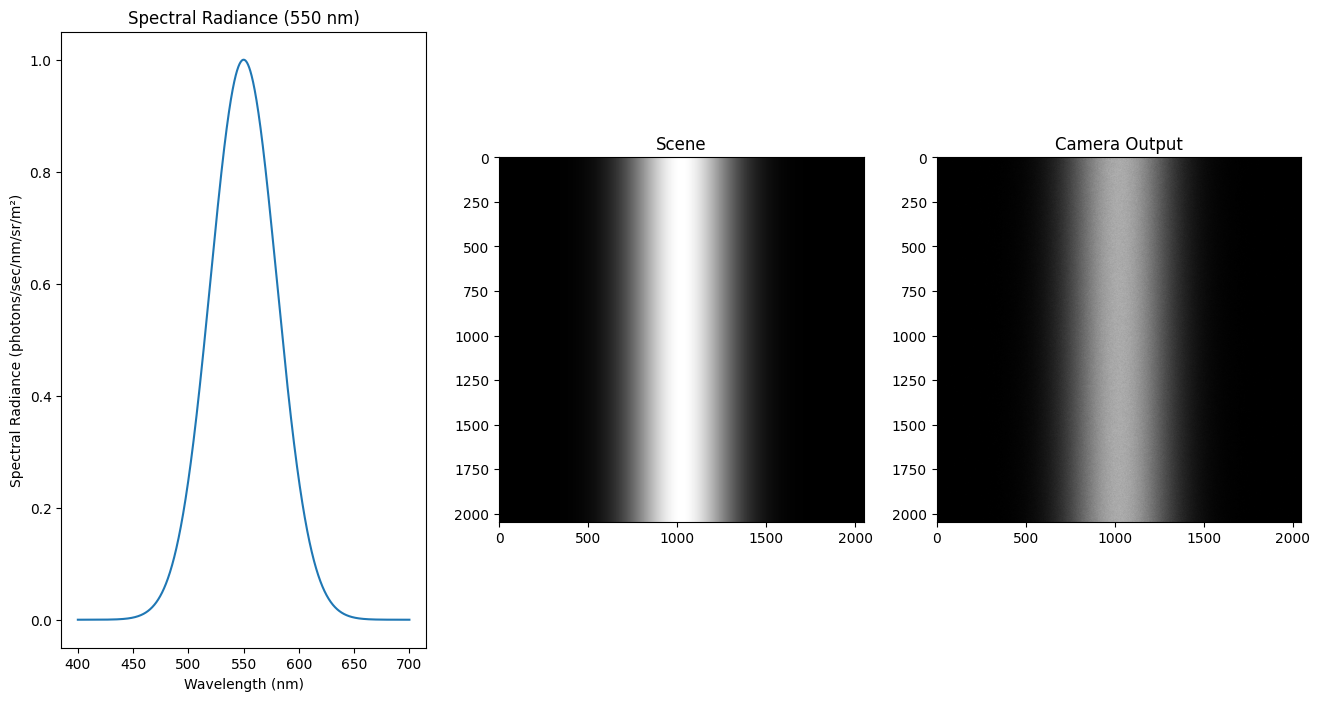

0.2505402916810058 42.75744249379444


In [8]:
# Display the scene and camera output (Only run if Scene 1 is used)
if scene_type == '2D Gauss':
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Scene")
    plt.imshow(scene, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Camera Output")
    plt.imshow(camera_output, cmap='gray')

elif scene_type == "Simple SpecRad":
    # Display the scene and camera output (Only run if Scene 2 is used)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.title("Spectral Radiance (550 nm)")
    plt.plot(wavelengths, scene[image_height // 2, :])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral Radiance (photons/sec/nm/sr/m²)")

    #plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 2)
    plt.title("Scene")
    plt.imshow(scene, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Camera Output")
    plt.imshow(camera_output, cmap='gray')

elif scene_type == "Macbeth":
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Spectral Radiance (550 nm)")
    plt.plot(wavelengths, scene[1, :])  # Display the radiance of the second color patch
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral Radiance (photons/sec/nm/sr/m²)")

    #plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 2)
    plt.title("Scene")
    plt.imshow(scene, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Camera Output")
    plt.imshow(camera_output, cmap='gray')

else:
    print("Invalid scene type provided") 

plt.show()

scene_mean = np.mean(scene)
camera_output_mean = np.mean(camera_output)
print(scene_mean, camera_output_mean)

### Trying EMVA Camera Simulator (based on Algolux tutorial)

1. Import sample png image: This image will form the basis of the "scene" simulation. I.e., imagine this image is the "scene" captured by the camera. 

/var/folders/jz/7t_94n991b13sn849gsrqnx00000gp/T/ipykernel_141/3722508152.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("MoCam2_Picture_Colorized_50ms.png")


(2048, 2048, 3)

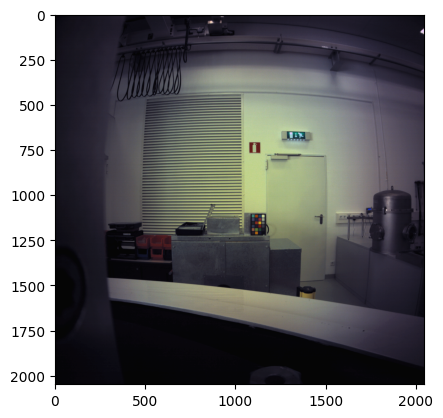

In [103]:
img = imageio.imread("M2_Picture_Colorized_50ms.png")
h, w = img.shape[:-1]
plt.imshow(img)
img.shape

2. Simulate the radiance spectrum of the image: As this image is simulated a real-world scene, we want to get a simulation of the radiance (or reflectance) spectrum of this scene. This is done below.

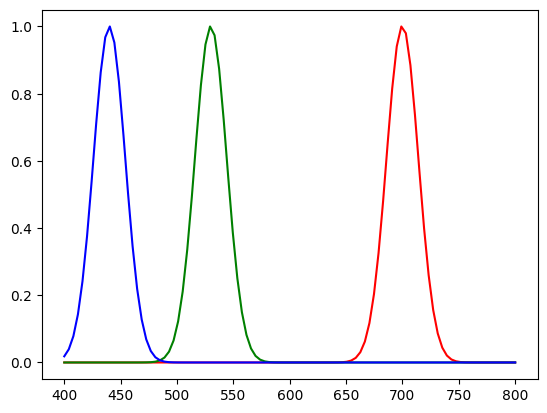

In [104]:
# Peak Wavelength values for R, G, and B

r,g,b = (700,530,440)

# Consider wavelengths from 400 nm to 800 nm

dom = np.linspace(400, 800, 100)

# Build nromal distributions centered around each peak wavelength

sig = 200
red = 1/(2*np.pi*sig) * np.exp(-((dom-r)**2)/(2*sig))
green = 1/(2*np.pi*sig) * np.exp(-((dom-g)**2)/(2*sig))
blue = 1/(2*np.pi*sig) * np.exp(-((dom-b)**2)/(2*sig))

# Normalise values

red /= np.max(red)
green /= np.max(green)
blue /= np.max(blue)

# Multiply each channel of each pixel with its corresponding photon distribution and sum up the channels

spectrum = np.einsum('ij,k->ijk', img[:, :, 0].astype(float), red) + \
            np.einsum('ij,k->ijk', img[:, :, 1].astype(float), green) + \
            np.einsum('ij,k->ijk', img[:, :, 2].astype(float), blue)

plt.plot(dom, red, 'r')
plt.plot(dom, green, 'g')
plt.plot(dom, blue, 'b')



3. Transform the pixels: The plot below simply visualizes the simulated spectrum of a single pixel of the scene. This is of course an approximation, as the real spectrum would be continuous and noisier

pixel (100,100): , r: 22, g: 19, b: 27


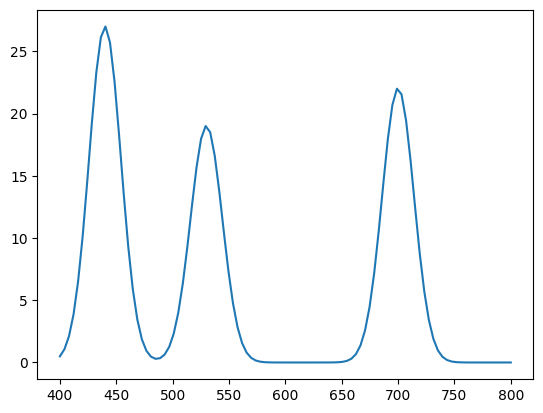

In [105]:
# Visualise result of the transformation

print('pixel (100,100): , r: %s, g: %s, b: %s' % (img[100,100,0], img[100,100,1], img[100,100,2]))
plt.plot(dom,spectrum[100,100,:])

4. EMVA1288 Camera Simulator

The camera simulator is contained in the Camera class of the emva1288 library (https://emva1288.readthedocs.io/en/latest/_modules/emva1288/camera/camera.html#Camera). This class allows one to simulate any camera by tuning the parameters of the class (e.g. f_number or qe), if one knows them for the camera one wishes to simulate. 

In [106]:
# Confirm width and height of image

print(h,w)

2048 2048


In [79]:
# Import emva1288 library and necessary classes

from emva1288.camera import Camera
from emva1288.camera.routines import Qe, get_bayer_filter

One can use the Bayer filter method to simulate a Bayer filter on top of the simulated sensor of the camera, and then calculate the corresponding QE with the Qe method, after which the results can be provided to the Camera class to simulate the response. 

The default Camera class already includes pre-defined parameters, which can be adjusted.

Below is an example with the default parameters of the Camera class:

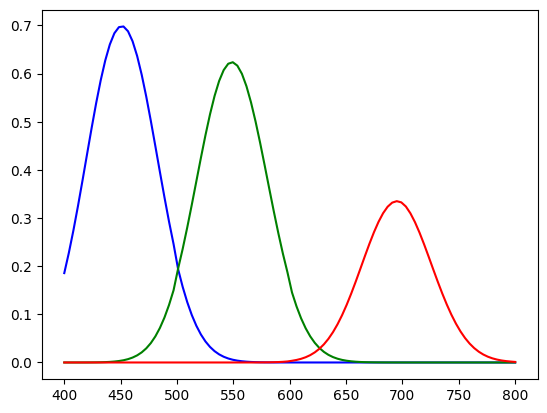

In [107]:
# Create a Bayer filter
filt = get_bayer_filter(450, 550, 550, 700, w, h, dom)

# Create QE object based on filter and image size
qe = Qe(filter = filt, width = w, height = h)

#### ran into issues with the above routine when w or h were odd numbers ####

# Initialise camera
cam = Camera(qe = qe, width = w, height = h)

# Plot QE for each pixel type (R, G or B)
plt.plot(dom, qe.qe[0,0], 'b')
plt.plot(dom, qe.qe[1,0], 'g')
plt.plot(dom, qe.qe[1,1], 'r')

In [81]:
#print("Filter shape:", filt.shape)
#print("Qe shape:", qe._qe.shape)
#print("Spectrum shape:", spectrum.shape)

After the above, the pixel values as seen by the Camera is already simulated in "cam". The grab method generates the simulated image using the EMVA1288 parameters and a normal distribution for each pixel

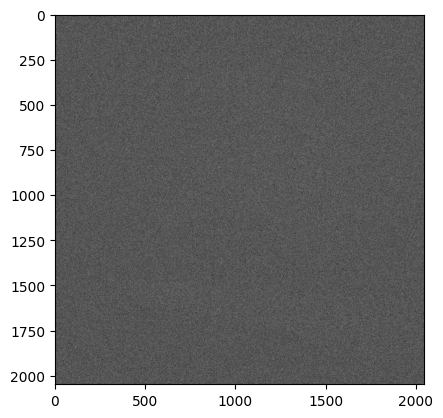

In [109]:
# Use get_radiance_for to get a reasonable number of photons that hit the sensor
factor = np.mean(cam.get_radiance_for(255))/np.mean(spectrum)

# Generate simulated image and display it
cap = cam.grab(factor * spectrum)
plt.imshow(cap, cmap = 'gray')

The above simulated image is still "Bayerised" (because we added a Bayer filter). We can see the Bayer pattern if we zoom in: 

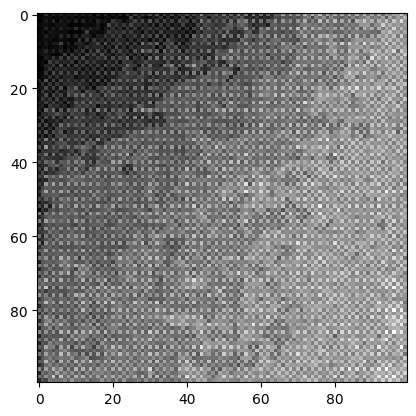

In [84]:
# Zoom in

plt.imshow(cap[:100,:100],cmap = 'gray')

Now, OpenCV can be used to De-bayerise the image and get the full colour image of the scene as the "camera" would see it (remember that this is the default Camera from the emva1288 library)

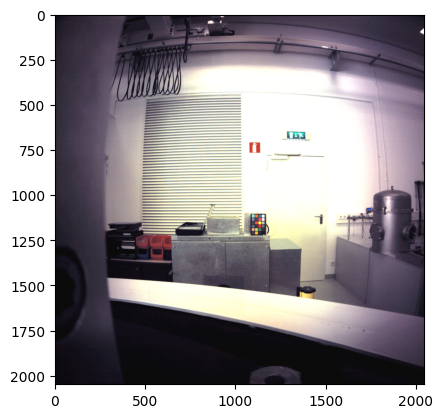

In [85]:
#!pip install opencv-python
import cv2

# Debayerise the simulated image
colour1 = cv2.cvtColor(cap, cv2.COLOR_BAYER_BG2BGR)
plt.imshow(colour1)


So now, we can try and make a custom camera with e.g. the AMS CMV4000 sensor

# CMV4000 Simulated Camera

In [114]:
"""Camera simulator init method.

        Parameters
        ----------
        f_number : float, optional
                   The emva1288 f_number for the camera.
        pixel_area : float, optional
                     The area of one pixel (in um ^ 2)
        bit_depth : int, optional
                    The number of bits allowed for one pixel value.
        width : int, optional
                The number of columns in the the image.
        height : int, optional
                The number of rows in the image.
        temperature : float, optional
                      The camera's sensor temperature in degrees Celsius.
        temperature_ref : float, optional
                          The reference temperature (at which the dark current
                          is equal to the reference dark current).
        temperature_doubling: float, optional
                              The doubling temperature (at which the dark
                              current is two times the reference dark
                              current).
        qe : float, optional
             Quantum efficiency (between 0 and 1). If None, a simulated
             quantum efficiency is choosen with the
             :func:`~emva1288.camera.routines.qe` function.
        exposure : float, optional
                   The camera's exposure time in ns.
        exposure_min : float, optional
                       The camera's minimal exposure time in ns.
        exposure_max : float, optional
                       The camera's maximal exposure time in ns.
        K : float, optional
            The overall system gain (in DN/e^-).
        K_min : float, optional
                The overall minimal system gain (in DN/e^-).
        K_max : float, optional
                The overall maximal system gain (in DN/e^-).
        K_steps : int, optional
                  The number of available intermediate overall system gains
                  between K_min and K_max.
        blackoffset : float, optional
                      The dark signal offset for each pixel (in DN).
        blackoffset_min: float, optional
                         The minimal dark signal offset for each pixel (in DN).
        blackoffset_max : float, optional
                          The maximal dark signal offset for each pixel
                          (in DN).
        blackoffset_steps : int, optional
                            The number of available blackoffsets between the
                            mimimal and maximal blackoffsets.
        dark_current_ref : float, optional
                           The reference dark current used for computing the
                           total dark current.
        dark_signal_0 : float, optional
            Mean number of electrons generated by the electronics (offset)
        sigma2_dark_0 : float, optional
            Variance of electrons generated by the electronics
        u_esat : float, optional
            Full well capacity
        dsnu : np.array, optional
               DSNU image in e^-, array with the same shape of the image
               that is added to every image.
        prnu : np.array, optional
               PRNU image in percentages (1 = 100%), array with the same shape
               of the image. Every image is multiplied by it.
        seed : int, optional
               A seed to initialize the random number generator.
        """



# User-provided parameters
f_number = 8
pixel_area = 30.25  # um^2
bit_depth = 8
width = 2048
height = 2048
temperature = 25
exposure = 100000  # in ns (I think this is wrong. It is actually in microseconds)
K = 0.024
blackoffset = 16315 # This is the blacklevel, which for the CMV4000 can be on the order of 16000
dark_signal_0 = 548.7
#sigma2_dark_0 = 
u_esat = 13937

# Define QE array
# Can be the one defined above for an RGGB Bayer pattern, or the one here for a monochrome (with a 50.2% QE at 535 nm, typical of a CMV4000)

# Create QE instance with the original gen_qe method
qe_instance = Qe(width=width, height=height)

# Manually set the desired QE value at 535 nm
center_wavelength = 535  # in nm
center_index = np.argmin(np.abs(qe_instance.w - center_wavelength))
qe_instance.qe[:, :, center_index] = 0.502 # desired QE value at 535 nm


# Create Camera instance with user-provided parameters
cmv4000_camera = Camera(
    f_number=f_number,
    pixel_area=pixel_area,
    bit_depth=bit_depth,
    width=width,
    height=height,
    temperature=temperature,
    qe=qe_instance,
    exposure=exposure,
    K=K,
    blackoffset=blackoffset,
    u_esat=u_esat
)

# Now you can use the custom_camera instance to generate images
# For example, assuming you have a radiance array
radiance = factor * spectrum  # Replace with your radiance array
simulated_image = cmv4000_camera.grab(radiance)
plt.imshow(simulated_image, cmap = "gray")


In [111]:
np.mean(simulated_image), np.max(simulated_image), np.min(simulated_image)

(139.5999310016632, 255, 22)

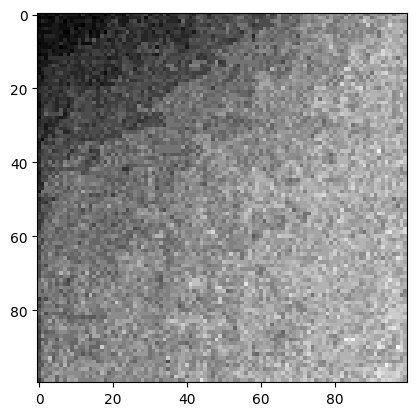

In [99]:
# Zoom in

plt.imshow(simulated_image[:100,:100],cmap = 'gray')

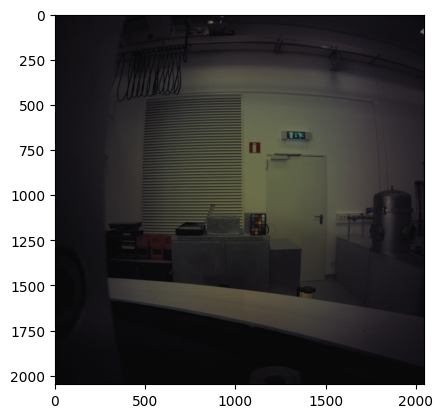

In [92]:
# Debayerise the simulated image if necessary
colour2 = cv2.cvtColor(simulated_image, cv2.COLOR_BAYER_BG2BGR)
plt.imshow(colour2)